# ECE-GY 7123 - Deep Learning
# ASSIGNMENT
## Done by: SUDHARSAN ANANTH

In [ ]:
# imports

import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5), 
    #transforms.RandomPerspective(distortion_scale=0.10, p=0.5), # random perspective transformation with a given probability.
    #transforms.RandomRotation(degrees=(-20,20)),
    #transforms.RandomHorizontalFlip(p=0.5),  
])

In [ ]:
trainset = datasets.CIFAR10("CIFAR10", train=True, transform=transform, download= True)
testset = datasets.CIFAR10("CIFAR10", train=False, transform=transform, download= True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [ ]:
 len(trainset)

50000

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
x,y = next(iter(trainloader))
print("The size of image batch is {}" .format(x.size()))
print("The size of label batch is {}" .format(y.size()))

The size of image batch is torch.Size([64, 1, 32, 32])
The size of label batch is torch.Size([64])


In [ ]:
# just to check if its normalized peoperly
print(x[0].view(-1).max())
print(x[0].view(-1).min())

tensor(0.6314)
tensor(-0.7098)


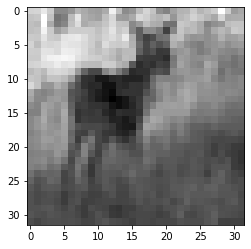

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x[3].view(32,-1),cmap="gray")

In [ ]:
torch.cuda.is_available()

False

In [ ]:
torch.cuda.device_count()

0

In [ ]:
class Classifier_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
       
    def forward(self,x):
        x = x.view(x.shape[0], -1) # flatten the images
        x = F.relu(self.fc1(x)) # first fully connected dense layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1) # Output layer
        
        return x

In [ ]:
model = Classifier_model()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model.parameters)

<bound method Module.parameters of Classifier_model(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)>


In [ ]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs, device='cpu'):

  print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

  history = {}
  history['loss'] = []
  history['val_loss'] = []
  history['acc'] = []
  history['val_acc'] = []

  start_time_sec = time.time()

  for epoch in range(0, epochs):

    # --- TRAIN AND EVALUATE ON TRAINING SET ----
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0

    for batch in train_dl:

      optimizer.zero_grad()

      x = batch[0].to(device)
      y = batch[1].to(device)
      yhat = model(x)
      loss = loss_fn(yhat,y)

      loss.backward()
      optimizer.step()

      train_loss          += loss.data.item() *x.size(0)
      num_train_correct   += (torch.max(yhat, 1)[1] == y).sum().item() # 
      num_train_examples  += x.shape[0]     

    train_acc = num_train_correct / num_train_examples 
    train_loss = train_loss/ len(train_dl.dataset)  # len(train_dl.dataset) --> number of data integer

    # ---EVALUATE ON VALIDATION SET ---
    model.eval()
    val_loss         = 0.0
    num_val_correct  = 0
    num_val_examples = 0

    for batch in val_dl:
      x = batch[0].to(device)
      y = batch[1].to(device)
      yhat = model(x)
      loss = loss_fn(yhat, y)

      val_loss           += loss.data.item() * x.size(0)
      num_val_correct    += (torch.max(yhat,1)[1] == y).sum().item()
      num_val_examples   += y.shape[0]

    val_acc = num_val_correct / num_val_examples
    val_loss = val_loss/len(val_dl.dataset)

    
    print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch, epochs, train_loss, train_acc, val_loss, val_acc))
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)

  # END OF TRAINING LOOP
  end_time_sec       = time.time()
  total_time_sec     = end_time_sec - start_time_sec
  time_per_epoch_sec = total_time_sec / epochs
  print()
  print('Time total:     %5.2f sec' % (total_time_sec))
  print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

  return history

In [ ]:
history = train(model, optimizer, loss, trainloader, testloader, 200, device='cpu') # training for 150 eopchs is enough

train() called: model=Classifier_model, opt=SGD(lr=0.010000), epochs=200, device=cpu

Epoch   0/200, train loss:  2.28, train acc:  0.16, val loss:  2.25, val acc:  0.20
Epoch   1/200, train loss:  2.19, train acc:  0.22, val loss:  2.13, val acc:  0.24
Epoch   2/200, train loss:  2.09, train acc:  0.26, val loss:  2.04, val acc:  0.27
Epoch   3/200, train loss:  2.01, train acc:  0.28, val loss:  1.97, val acc:  0.29
Epoch   4/200, train loss:  1.94, train acc:  0.30, val loss:  1.92, val acc:  0.32
Epoch   5/200, train loss:  1.89, train acc:  0.32, val loss:  1.87, val acc:  0.33
Epoch   6/200, train loss:  1.84, train acc:  0.34, val loss:  1.83, val acc:  0.35
Epoch   7/200, train loss:  1.80, train acc:  0.36, val loss:  1.79, val acc:  0.36
Epoch   8/200, train loss:  1.76, train acc:  0.38, val loss:  1.76, val acc:  0.38
Epoch   9/200, train loss:  1.72, train acc:  0.39, val loss:  1.73, val acc:  0.38
Epoch  10/200, train loss:  1.68, train acc:  0.40, val loss:  1.70, val a

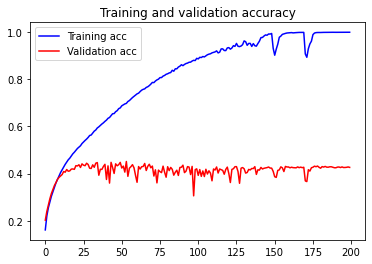

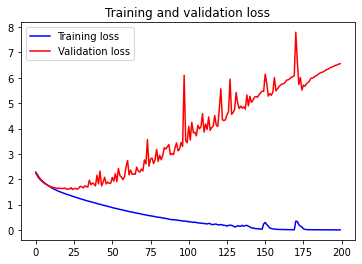

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(0, 200)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

tensor([-3.1991e+01, -5.2090e+01, -2.0646e+01, -1.9740e+01, -2.7091e+01,
        -1.6798e+01, -4.9940e+01, -1.1921e-07, -5.8219e+01, -1.7981e+01],
       grad_fn=<SelectBackward0>)
tensor(7)
tensor(-1.1921e-07, grad_fn=<UnbindBackward0>)


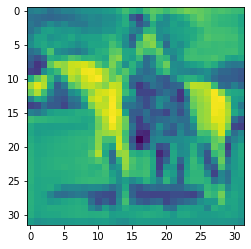

In [ ]:
x,y = next(iter(trainloader))

model.eval()
pred = model(x)

print(pred[2])

plt.imshow(x[2].squeeze())
print(y[2])
print(max(pred[2]))

CIFAR 10 CLASSES
0. airplanes, 
1. cars, 
2. birds, 
3. cats, 
4. deer, 
5. dogs, 
6. frogs, 
7. horses, 
8. ships,
9. trucks


As you can see the model correctly predicted bird which agrees with the Y label. so our model is doing quite good in training data set

In [ ]:
# test accuracy
print("the test accuracy is pretty bad though {}%".format((history['val_acc'][-1])*100))

the test accuracy is pretty bad though 42.64%


The charts and the results indicate that we have over-fit our model. using a better optimizer adding more layers would help this model. 